In [1]:
import requests
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
import time
from time import sleep
import random
import re
from tqdm import tqdm

## 1. Create a list of all large cities (they are on the page https://prodoctorov.ru/town/)

In [8]:
path = 'C:\Program Files\msedgedriver.exe'
driver = webdriver.Edge(path)
url = 'https://prodoctorov.ru/town/'
driver.get(url)
html_content = driver.page_source
soup = BeautifulSoup(html_content)
cities_html = soup.find_all('a', {'class': 'list-links__link'})
cities_links = [f'https://prodoctorov.ru/{city_translit}/vrach/' for city_translit in \
                [citi_html.get('data-translit') for citi_html in cities_html]]
driver.quit

<bound method WebDriver.quit of <selenium.webdriver.edge.webdriver.WebDriver (session="b560c12190923bfa3f1091bc3411e272")>>

In [10]:
cities_links[:6]

['https://prodoctorov.ru/angarsk/vrach/',
 'https://prodoctorov.ru/arhangelsk/vrach/',
 'https://prodoctorov.ru/astrahan/vrach/',
 'https://prodoctorov.ru/balashiha/vrach/',
 'https://prodoctorov.ru/barnaul/vrach/',
 'https://prodoctorov.ru/belgorod/vrach/']

In [16]:
# since the website blocks suspicious activity and uses CAPTCHA we need to use more sophisticated methods
# to retrieve data. For this case I have chosen selenium package, but it turns out to be very slow so 
# we retrieve data only for Moscow doctors 

for city_link in cities_links:
    if 'moskva' in city_link:
        url = (str(city_link))
url

'https://prodoctorov.ru/moskva/vrach/'

## 2. Get a list of links of all doctors specialities in Moscow

In [ ]:
# code to loop for every city

# path = 'C:\Program Files\msedgedriver.exe'
# driver = webdriver.Edge(path)
# specs_links = []

# for city_link in tqdm():
#     driver.get(city_link)
#     html_content = driver.page_source
#     soup = BeautifulSoup(html_content, 'html.parser')
#     specs = soup.find_all('a', {'class': 'p-doctors-list-page__tab-item-link b-text-unit_hover_solid ui-text ui-text_body-2'})
#     for spec in specs:
#         res = spec.get('href')
#         specs_links.append('https://prodoctorov.ru' + res)
# driver.quit()

In [18]:
# code w/o loop (only Moscow)

path = 'C:\Program Files\msedgedriver.exe'
driver = webdriver.Edge(path)
specs_links = []
driver.get('https://prodoctorov.ru/moskva/vrach/')
html_content = driver.page_source
soup = BeautifulSoup(html_content, 'html.parser')
specs = soup.find_all('a', {'class': 'p-doctors-list-page__tab-item-link b-text-unit_hover_solid ui-text ui-text_body-2'})
for spec in specs:
    res = spec.get('href')
    specs_links.append('https://prodoctorov.ru' + res)
driver.quit()

In [5]:
len(specs_links)

159

In [19]:
specs_links[:5]

['https://prodoctorov.ru/moskva/abdominalniy-hirurg/',
 'https://prodoctorov.ru/moskva/akusher/',
 'https://prodoctorov.ru/moskva/akusherka/',
 'https://prodoctorov.ru/moskva/algolog/',
 'https://prodoctorov.ru/moskva/allergolog/']

## 3. Get doctors' info from all of the pages of every speciality in Moscow

In [61]:
def get_doctor_info(url, driver):
    """
    Функция возвращает список словарей с информацией о докторе на всех страницах, доступных по ссылке.

    Параметры: ссылка на страницу врача, объект веб-драйвера Selenium
    """
    doctor_info = []
    page_num = 1
    while True:
        try:
            driver.get(f'{url}?page={page_num}')
            # find all the doctor cards
            doctor_cards = driver.find_elements_by_css_selector('div.b-doctor-card')

            # iterate through each doctor card
            for card in doctor_cards:
                # extract the doctor's name
                name_element = card.find_element_by_css_selector('a.b-doctor-card__name-link span.b-doctor-card__name-surname')
                name = name_element.text

                # extract the doctor's url
                doc_url_element = card.find_element_by_css_selector('a.b-doctor-card__name-link')
                doc_url = doc_url_element.get_attribute('href')

                # extract the doctor's price, if available
                try:
                    price_elem = card.find_element_by_css_selector('div[data-qa="club__sliderTabPrice"]')
                    price_text = price_elem.text.strip()
                    price = re.search(r'\d+', price_text).group()
                except:
                    price = ''

                # extract the doctor's speciality
                speciality_element = card.find_element_by_css_selector('div.b-doctor-card__spec')
                speciality = ' '.join(speciality_element.text.strip().split())

                # extract the doctor's experience
                try:
                    exp_elem = card.find_element_by_class_name('b-doctor-card__experience-years')
                    experience = re.search(r'\d+', exp_elem.text).group()
                except:
                    experience = ''

                # extract the doctor's category, if available
                try:
                    category_element = card.find_element_by_css_selector('div.b-doctor-card__category span')
                    category = category_element.text
                except:
                    category = ''

                # append the doctor information to the list
                doctor_info.append({'name': name, 'url': doc_url, 'price': price, 'spec': speciality, 'exp': experience, 'cat': category})
                    
            next_link = driver.find_elements_by_css_selector('a.b-pagination-vuetify-imitation__item.b-pagination-vuetify-imitation__item_next')
            if not next_link:
                break
            page_num += 1
        except:
            break
    return doctor_info

## 4. Iterate through every speciality

In [65]:
path = 'C:\\Program Files\\msedgedriver.exe'
driver = webdriver.Edge(path)
all_doctor_info = []
for spec_link in tqdm(specs_links):
    all_doctor_info += get_doctor_info(spec_link, driver)
driver.quit()

100%|█████████████████████████████████████████████████████████████████████████████| 159/159 [5:58:52<00:00, 135.42s/it]


## 5. EDA

In [339]:
# load data
all_doctor_info_df = pd.DataFrame(all_doctor_info)

In [293]:
# save to file
all_doctor_info_df.to_csv(os.getcwd() + '//all_doctor_info_df.csv')

In [340]:
# convert price and exp to int
all_doctor_info_df['price'] = pd.to_numeric(all_doctor_info_df['price'], errors='coerce')
all_doctor_info_df['exp'] = pd.to_numeric(all_doctor_info_df['exp'], errors='coerce')

In [296]:
all_doctor_info_df.head(5)

,name,url,price,spec,exp,cat
0,Арутюнян Генрик Маратович,https://prodoctorov.ru/moskva/vrach/316814-aru...,2450.0,"Хирург, абдоминальный хирург, артролог, врач У...",14.0,Высшая категория
1,Гибадулин Наиль Валерианович,https://prodoctorov.ru/moskva/vrach/362536-gib...,7000.0,"Хирург, абдоминальный хирург, бариатрический х...",30.0,"Высшая категория,"
2,Прохоров Юрий Анатольевич,https://prodoctorov.ru/moskva/vrach/64936-proh...,1.0,"Хирург, абдоминальный хирург, малоинвазивный х...",34.0,к.м.н
3,Знаменский Алексей Алексеевич,https://prodoctorov.ru/moskva/vrach/179284-zna...,4000.0,"Абдоминальный хирург, бариатрический хирург, х...",43.0,к.м.н
4,Станкевич Владимир Романович,https://prodoctorov.ru/moskva/vrach/78782-stan...,2800.0,"Хирург, абдоминальный хирург, бариатрический х...",25.0,"Высшая категория,"


In [ ]:
# find rows with missing category
missing_cat_df = all_doctor_info_df[all_doctor_info_df['cat'].isin(['1 категория,', '2 категория,', 'Высшая категория,'])].copy()

# missing_cat = ['1 категория,', '2 категория,', 'Высшая категория,']
# missing_cat_df_ = all_doctor_info_df[all_doctor_info_df['cat'].isin(missing_cat)]

In [297]:
missing_cat_df.head()

,name,url,price,spec,exp,cat
1,Гибадулин Наиль Валерианович,https://prodoctorov.ru/moskva/vrach/362536-gib...,7000,"Хирург, абдоминальный хирург, бариатрический х...",30,"Высшая категория, Профессор"
4,Станкевич Владимир Романович,https://prodoctorov.ru/moskva/vrach/78782-stan...,2800,"Хирург, абдоминальный хирург, бариатрический х...",25,"Высшая категория, Кандидат наук"
6,Луцевич Олег Эммануилович,https://prodoctorov.ru/moskva/vrach/64935-luce...,2000,"Хирург, абдоминальный хирург",44,"Высшая категория, Доктор наук"
9,Иванов Юрий Викторович,https://prodoctorov.ru/moskva/vrach/33393-ivanov/,4400,"Хирург, абдоминальный хирург, онколог",30,"Высшая категория, Профессор"
12,Смирнов Алексей Николаевич,https://prodoctorov.ru/moskva/vrach/31360-smir...,5500,"Абдоминальный хирург, детский хирург, проктоло...",48,"Высшая категория, Профессор"


In [189]:
# use Selenium to find missing categories
path = 'C:\\Program Files\\msedgedriver.exe'
driver = webdriver.Edge(path)

# iterate through the DataFrame with tqdm
for index, row in tqdm(missing_cat_df.iterrows(), total=len(missing_cat_df)):
    # get the URL
    url = row['url']
    # navigate to the URL using the webdriver
    driver.get(url)
    # extract the necessary information using Selenium 
    new_cat_elements = driver.find_elements_by_css_selector('div.ui-text.ui-text_body-2.mt-1')
    new_cats = ', '.join([e.text for e in new_cat_elements])
    # update the corresponding row in the DataFrame
    missing_cat_df.loc[index, 'cat'] = new_cats

# close the webdriver instance
driver.quit()

100%|██████████████████████████████████████████████████████████████████████████| 10184/10184 [3:09:59<00:00,  1.12s/it]


In [191]:
# save file
missing_cat_df.to_csv(os.getcwd() + '//missing_cat_df.csv')

In [341]:
# update categories in main dataframe
all_doctor_info_df.update(missing_cat_df)

In [342]:
all_doctor_info_df.tail()

,name,url,price,spec,exp,cat
141427,Юркевич Эмма Андреевна,https://prodoctorov.ru/moskva/vrach/1024710-yu...,NaN,Стоматолог-ортодонт,3.0,
141428,Юрченко Анастасия Сергеевна,https://prodoctorov.ru/moskva/vrach/1004763-yu...,NaN,Стоматолог-ортодонт,NaN,
141429,Якубова Мака Шахиевна,https://prodoctorov.ru/moskva/vrach/32303-yaku...,NaN,"Стоматолог, стоматолог-ортодонт",23.0,к.м.н
141430,Ямашева Александра Игоревна,https://prodoctorov.ru/moskva/vrach/925022-yam...,NaN,Стоматолог-ортодонт,17.0,
141431,Яркин Вадим Витальевич,https://prodoctorov.ru/moskva/vrach/562852-yar...,0.0,"Стоматолог-ортопед, стоматолог-ортодонт",22.0,"Высшая категория, Кандидат наук"


In [343]:
# replace low prices and empty strings with NaN
all_doctor_info_df['price'] = all_doctor_info_df['price'].apply(lambda x: np.nan if isinstance(x, (int, float)) and x < 500 else x)
all_doctor_info_df = all_doctor_info_df.replace('', np.nan)

In [344]:
# remove duplicates
all_doctor_info_df.drop_duplicates(inplace=True)

In [345]:
# clean up specialities column
all_doctor_info_df['spec'] = all_doctor_info_df['spec'].apply(lambda x: x.split(',')[0].strip())

In [346]:
# calculate the IQR of the 'price' column
Q1 = all_doctor_info_df['price'].quantile(0.25)
Q3 = all_doctor_info_df['price'].quantile(0.75)
IQR = Q3 - Q1

# remove outliers beyond 1.5*IQR range
all_doctor_info_df = all_doctor_info_df[~((all_doctor_info_df['price'] < (Q1 - 1.5 * IQR)) | (all_doctor_info_df['price'] > (Q3 + 1.5 * IQR)))]

In [347]:
# calculate average price by category
all_doctor_info_df.groupby('cat')['price'].mean().sort_values(ascending=True)

cat
1 категория                        2501.515
Высшая категория                   2600.609
2 категория                        2718.654
2 категория, Кандидат наук         2810.588
Высшая категория, Кандидат наук    3145.281
к.м.н                              3293.596
1 категория, Кандидат наук         3298.103
1 категория, Профессор             3450.000
Высшая категория, Доктор наук      4153.000
Профессор                          4345.088
д.м.н.                             4374.283
Высшая категория, Профессор        4378.149
1 категория, Доктор наук           5250.000
2 категория, Доктор наук                NaN
Name: price, dtype: float64

In [349]:
# calculate average price by speciality
all_doctor_info_df.groupby('spec')['price'].mean().dropna().sort_values(ascending=False)

spec
Химиотерапевт                                        7130.000
Радиолог                                             5877.083
Гомеопат                                             5700.000
Сексолог                                             5250.000
Радиотерапевт                                        5060.000
Алголог                                              5000.000
Детский остеопат                                     5000.000
Остеопат                                             4864.392
Детский психиатр                                     4829.714
Психотерапевт                                        4799.188
Детский гематолог                                    4766.667
Психиатр                                             4738.971
Сомнолог                                             4691.667
Генетик                                              4535.135
Детский инфекционист                                 4520.000
Клинический психолог                                 4511.591
Пси

In [350]:
all_doctor_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103410 entries, 0 to 141430
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    103410 non-null  object 
 1   url     103410 non-null  object 
 2   price   18186 non-null   float64
 3   spec    103410 non-null  object 
 4   exp     93204 non-null   float64
 5   cat     31980 non-null   object 
dtypes: float64(2), object(4)
memory usage: 5.5+ MB


In [351]:
all_doctor_info_df.isnull().sum()

name         0
url          0
price    85224
spec         0
exp      10206
cat      71430
dtype: int64

In [352]:
all_doctor_info_df.describe()

,price,exp
count,18186.000,93204.000
mean,2725.407,21.299
std,1498.664,12.176
min,500.000,0.000
25%,1680.000,11.000
50%,2360.000,20.000
75%,3500.000,30.000
max,7300.000,71.000


<Axes: >

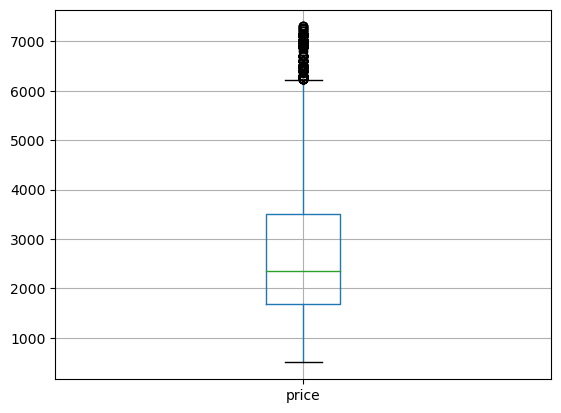

In [353]:
all_doctor_info_df.boxplot(column=['price'])

In [354]:
all_doctor_info_df.groupby('spec').agg({'price': ['mean', 'median', 'std', 'count'], 'exp': ['mean', 'median', 'std', 'count']})

price                    \
                                                       mean  median       std   
spec                                                                            
Абдоминальный хирург                               4035.000  3940.0  1125.033   
Акушер                                             2768.970  2390.0  1388.220   
Акушерка                                           2100.000  2100.0       NaN   
Алголог                                            5000.000  5000.0       NaN   
Аллерголог                                         2896.374  2475.0  1164.938   
Андролог                                           3216.667  2800.0  1456.229   
Анестезиолог-реаниматолог                          2738.880  2200.0  1480.457   
Аритмолог                                          3633.077  2900.0  1758.486   
Артролог                                           1874.000  1925.0   652.995   
Бариатрический хирург                               500.000   500.0       NaN   
Венеролог                                          2213.026  2137.5   734.617   
Вертебролог                                        3171.316  2500.0  1833.601   
Врач ЛФК                                           3278.258  2900.0  1563.880   
Врач УЗИ                                           1907.977  1500.0  1167.839   
Врач общей практики                                3473.667  2675.0  1808.324   
Врач подолог (подиатр)                             4000.000  4000.0  1504.161   
Врач скорой помощи                                 2189.714  2188.0     4.536   
Врач физической и реабилитационной медицины (ФРМ)  2000.000  2000.0       NaN   
Врач-косметолог                                    2442.896  2125.0  1230.522   
Гастроэнтеролог                                    3074.887  2600.0  1323.324   
Гематолог                                          3673.000  3500.0  1372.546   
Гемостазиолог                                      4300.000  4000.0   608.276   
Генетик                                            4535.135  4000.0  1383.025   
Гепатолог                                          3201.818  3000.0  1390.660   
Гериатр (геронтолог)                               2500.000  2500.0   707.107   
Гинеколог                                          2711.120  2390.0  1356.713   
Гинеколог-хирург                                   3915.833  3750.0  1449.611   
Гинеколог-эндокринолог                             2473.935  2300.0   960.037   
Гипнолог                                           4250.000  4250.0  1060.660   
Гирудотерапевт                                     2000.714  2200.0   500.806   
Гнатолог                                           2707.692  2500.0  1645.809   
Гнойный хирург                                          NaN     NaN       NaN   
Гомеопат                                           5700.000  5500.0   941.630   
Дерматолог                                         2528.374  2300.0  1069.997   
Детский ЛОР                                        3162.260  2600.0  1398.001   
Детский аллерголог                                 3076.515  2450.0  1241.154   
Детский гастроэнтеролог                            2699.091  2450.0  1178.254   
Детский гематолог                                  4766.667  4900.0  1703.917   
Детский гинеколог                                  2512.565  2200.0  1193.526   
Детский дерматолог                                 3504.500  2465.0  1769.836   
Детский инфекционист                               4520.000  4520.0       NaN   
Детский кардиолог                                  3369.487  2450.0  1662.503   
Детский массажист                                  2222.679  1650.0  1525.918   
Детский невролог                                   3340.123  3000.0  1357.425   
Детский нефролог                                   3583.583  3000.0  1433.382   
Детский онколог                                    3427.500  2380.0  2410.330   
Детский ортопед                                    3103.513  2500.0  1482.900   
Детс

<Axes: xlabel='cat'>

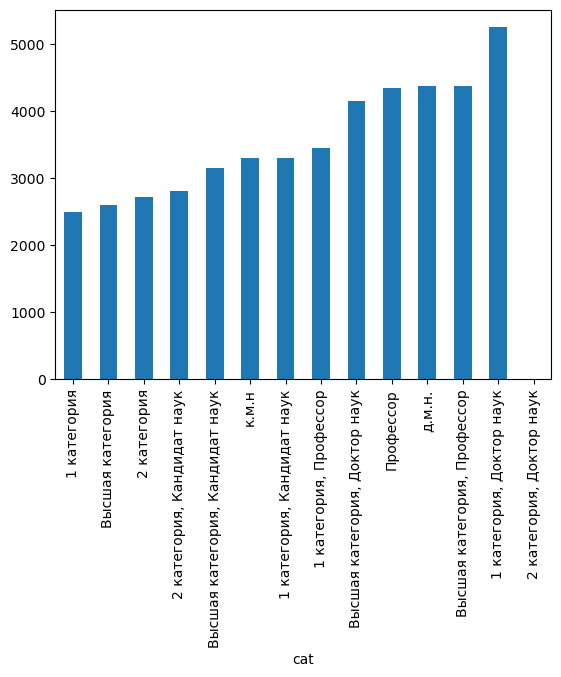

In [355]:
all_doctor_info_df.groupby('cat')['price'].mean().sort_values(ascending=True).plot(kind='bar')